In [ ]:
!pip install tensorflow
!pip install keras

     |████████████████████████████████| 462 kB 4.1 MB/s 


In [ ]:
!pip install "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 3.5 MB/s 


In [ ]:
import collections
import helper
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import re
import typing
from typing import Any, Tuple

from numpy import array
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from numpy import argmax
from keras.models import load_model
from keras.layers import Dropout
 
from keras.optimizers import gradient_descent_v2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.losses import sparse_categorical_crossentropy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
def load_data(path):
  source_file = "/content/drive/MyDrive/NLP/sentencesTrain.txt"
  target_file = "/content/drive/MyDrive/NLP/tokensTrain.txt"

  text_pairs_source = []
  text_pairs_target = []

  with open(source_file,encoding="cp1252") as file1, open(target_file,encoding="cp1252") as file2:
      for line1, line2 in zip(file1, file2):
          line1 = line1.replace("\n", " ")
          line1 = line1.strip()
          
          line2 = line2.replace(",", " ")
          line2 = line2.replace("\n", " ")
          line2 = line2.strip()
          text_pairs_source.append(line1)
          text_pairs_target.append(line2)
          print(line2)
  return text_pairs_target,text_pairs_source

In [ ]:
target, inp = load_data("")

(P)PARTY START WHICH TIME EIGHT TIME NINE (P)PARTY START WHICH TIME
(G/Q)POSS-1p SISTER (2h)IX-3p:i tube skipping on water IX-1p GO-BY-BOAT IX-1p LOOK MAKE REALLY person flips off IX-1p STOP SISTER (2h)IX-3p:i tube skipping on water GO-BY-BOAT MAKE STOP
MOTHER IX-loc:i #IF+ (1h)HAVE TIME+ IX-3p:i FUTURE BRING COOKIE TIME+ BRING COOKIE
#NO+ IX-1p NOT OLD ENOUGH TO/UNTIL VOTE THAT TIME part:indef ENOUGH TO/UNTIL VOTE TIME part:indef
FRIEND WANT_2 BUY PLAID (2h)SHIRT FRIEND WANT_2 BUY (2h)SHIRT
#IF TOMORROW SNOW GUARANTEE SCHOOL FUTURE CLOSE-DOOR SNOW GUARANTEE SCHOOL CLOSE-DOOR
IX-1p RECENT-PAST DRINK TASTE FINE++ (1h)part:indef
#IF MOTHERwg IX-3p:i NOT person walking SELL IX-1p-pl-arc REFUSE (1h)HAVE MILK part:indef SELL (1h)part:indef part:indef
FINEwg MOTHERwg FUTURE GIVE-1p TWENTY DOLLAR #IF IX-1p NICE/CLEAN (K)KITCHEN DOLLAR NICE/CLEAN (K)KITCHEN
TEACH+AGENT IX-loc:i IX-3p-pl-arc HEAR/LISTEN IX-3p:i WHO TEACH AGENT BUOY IX-3p:j
IX-1p RECENT-PAST READ+ BOOK IX-1p READ+ BOOK
EXPRESS T

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 120

dataset = tf.data.Dataset.from_tensor_slices((inp, target)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'My friend loves going fishing because he loves fresh fish for dinner.'
 b"Oh no, if there's a hurricane, the game is definitely cancelled."
 b'Why did you drink hard and pass out last night?'
 b"If I have to pay rent now, that is fine, I'll just cancel my vacation."
 b'Who tends to commute to work by bicycle?'], shape=(5,), dtype=string)

tf.Tensor(
[b'FRIEND IX-loc:i KISS-FIST GO (1h)FISHING++ (25)WHY LOVE NEW FISH FOR EAT+NIGHT+ FRIEND GO LOVE NEW FISH NIGHT+'
 b'PLEASE/(1h)ENJOY+ IF HURRICANE+ GAME+ DECIDE CANCEL/CRITICIZE HURRICANE+ GAME+ DECIDE CANCEL/CRITICIZE'
 b'person passed out (2h)DRUNK PAST_2+NIGHT (25)WHY (1h)part:indef person passed out (2h)DRUNK NIGHT'
 b'#IF REALLY+WORK IX-1p MUST (P)PAY fs-RENT NOW FINE CANCEL/CRITICIZE POSS-1p VACATION (1h)PROCEED+ WORK (P)PAY NOW CANCEL/CRITICIZE VACATION'
 b'(1h)TEND COMMUTE+ BICYCLE (1h)part:indef WHO BICYCLE'], shape=(5,), dtype=string)


In [ ]:
example_text = tf.constant(' Me llamo Sadia')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b' Me llamo Sadia'
b' Me llamo Sadia'


In [ ]:
def tf_lower_v3(text):
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_v3(example_text).numpy().decode())

 Me llamo Sadia
[START]  Me llamo Sadia [END]


In [ ]:
max_vocab_size = 7000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_v3,
    max_tokens=max_vocab_size)

In [ ]:
input_text_processor.adapt(inp)

input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'the', 'I', 'to', 'If', 'a', 'is']

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_v3,
    max_tokens=max_vocab_size)

output_text_processor.adapt(target)
output_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'IX-1p',
 'FRIEND',
 'IX-3p:i',
 'part:indef',
 'IX-loc:i',
 '(1h)part:indef']

In [ ]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   21,   15,   62,   52,  671,   18,   14,   62, 1246],
       [   2,  447,  362,   49,  148,    8,  647,    4,  113,    9],
       [   2,   45,   36,   13, 1308,  396,   12,  176,   38,   86]])>

In [ ]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] My friend loves going fishing because he loves fresh fish for dinner. [END]                 '

Text(0.5, 1.0, 'Mask')

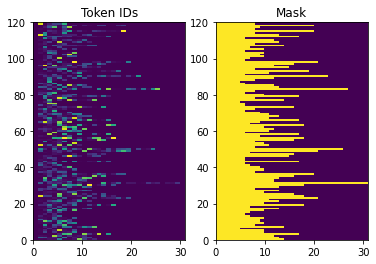

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
embedding_dim = 256
units = 1056

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (120,)
Input batch tokens, shape (batch, s): (120, 31)
Encoder output, shape (batch, s, units): (120, 31, 1056)
Encoder state, shape (batch, units): (120, 1056)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(units)

In [ ]:
(example_tokens != 0).shape

TensorShape([120, 31])

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (120, 2, 1056)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (120, 2, 31)


Text(0.5, 1.0, 'Mask')

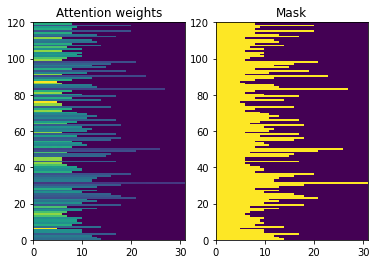

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
attention_weights.shape

TensorShape([120, 2, 31])

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

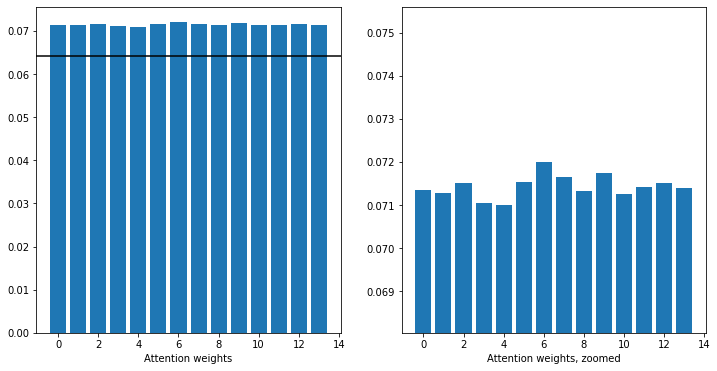

In [ ]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (120, 1, 1294)
state shape: (batch_size, dec_units) (120, 1056)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
np.log(output_text_processor.vocabulary_size())

7.165493475060845

In [ ]:
%%time
for n in range(20):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.6365757>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.610844>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.562038>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.4167337>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.802542>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=10.209235>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.0156393>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.5533824>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.620215>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.670111>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.5823383>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.416229>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2557>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4070716>}
{'batch_loss': <tf.Tensor: sh

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0928226>}

In [ ]:
%%time
for n in range(20):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0552745>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.015793>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.983183>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.966272>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.945903>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8983707>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.847956>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.811612>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7830324>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7533445>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.718259>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6779013>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.636208>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.599678>}
{'batch_loss': <tf.Tensor: sh

........................................................................................................................................................................................................


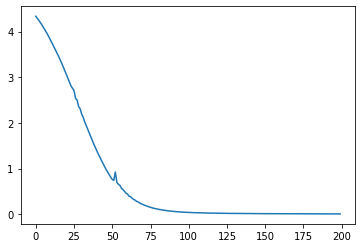

In [ ]:
losses = []
for n in range(200):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=20,callbacks=[batch_loss])

Epoch 1/20
6/6 [==============================] - 7s 1s/step - batch_loss: 5.6069
Epoch 2/20
6/6 [==============================] - 7s 1s/step - batch_loss: 5.4611
Epoch 3/20
6/6 [==============================] - 7s 1s/step - batch_loss: 5.2973
Epoch 4/20
6/6 [==============================] - 7s 1s/step - batch_loss: 5.1792
Epoch 5/20
6/6 [==============================] - 7s 1s/step - batch_loss: 5.0776
Epoch 6/20
6/6 [==============================] - 8s 1s/step - batch_loss: 4.9722
Epoch 7/20
6/6 [==============================] - 7s 1s/step - batch_loss: 4.8523
Epoch 8/20
6/6 [==============================] - 7s 1s/step - batch_loss: 4.7410
Epoch 9/20
6/6 [==============================] - 7s 1s/step - batch_loss: 4.5865
Epoch 10/20
6/6 [==============================] - 7s 1s/step - batch_loss: 4.4500
Epoch 11/20
6/6 [==============================] - 7s 1s/step - batch_loss: 4.2506
Epoch 12/20
6/6 [==============================] - 7s 1s/step - batch_loss: 4.0319
Epoch 13/20
6

Text(0, 0.5, 'CE/token')

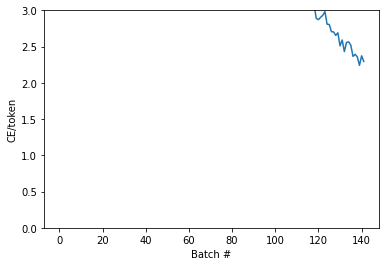

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'ALCOHOL+ EXHAUST', b'fs-MITT-ROMNEY ORGANIZE',
       b'FRISBEE COOK/KITCHEN', b'DEAF GLASSES_2',
       b'(2h)#NO+MORE SCHOOL+'], dtype=object)

In [ ]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1158],
       [ 763],
       [ 665],
       [ 445],
       [ 869]])>

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [ ]:
Translator.translate = translate_unrolled

In [ ]:
%%time
input_text = tf.constant([
    "I starting making an invitation list for my BBQ party, I will have to make sure it's right.", 
    "If Father arrives home late, he can’t help us with our homework.", 
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

IX-1p FILL-OUT FRIEND BRAVE/RECOVER AUNT NOW FINALLY MUST IX-1p PROCEED REQUEST REALLY REALLY BRING SUPPORT CLASS tube LAUGH-HARD STAY MONEY+ NIGHT
IX-1p FINISH BOOK AFRAID FOR GRANDMOTHER CLASS IX-1p HURRY FINISH WORK GRAB-CHANCE walking (2h)alt.EAT

CPU times: user 1.31 s, sys: 13.9 ms, total: 1.33 s
Wall time: 1.35 s


In [ ]:
test_file = "/content/drive/MyDrive/NLP/sentencesTest.txt"

outputfile = "sadia_sign_v2.txt"
out = open(outputfile, "w")

with open(test_file,encoding="cp1252" ) as f:
    lines_test = f.read().split("\n")[:-1]

for input_sentence in lines_test:
    
    
    #input_sentence = random.choice(line2)
    list_data = []
    list_data.append(input_sentence)
    input_text = tf.constant(list_data)
    result = translator.translate(input_text = input_text)

    #print(result['text'][0].numpy().decode())
    
    translated = result['text'][0].numpy().decode()
    translated = translated.replace(" ", ",")
    
    out.write(translated+'\n')

out.close()